In [18]:
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../../RKLM_Python/')
# Path to output files
sys.path.append('../')

import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal
import pickle

# For which test case do we plot?
`swe` is the shallow water vortex, `euler` the Euler vortex and `rb` the rising bubble.

In [31]:
swe = False
euler = False
rb = True

# Plot format for MWR or arXiv?
MWR = True
arXiv = False

## For given test case, load the relevant parameters

In [32]:
def load(base_fn,Nx,Ny,et,Nz=None):
    pydir = '../../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
    tags = tc.get_tag_dict()
    return tc, tags

if swe:
    base_fn = 'output_swe_vortex'
    Nx, Ny, Nz = 64, 1, 64
    et = 3.0
    tc, tags = load(base_fn,Nx,Ny,et,Nz)
    
    attr_labels = pt.swe_labels()
    attributes = ['rho','p2_nodes','rhou','rhow']
    obs_attrs = 'rhou_rhow'
    aux = 'wda'
    aux_ref = ''
    lbl = 'swe'
    times = np.arange(0.0,3.01,0.01)[1:]
    
    x_axs = [-0.5,0.0,0.5]
    y_axs = [-0.5,0.0,0.5]
    axs0, axs1 = Nx, Nz

elif euler:
    base_fn = "output_travelling_vortex"
    Nx, Ny = 64, 64
    et = 3.0
    tc, tags = load(base_fn,Nx,Ny,et)
    
    attr_labels = pt.labels()
    attributes = ['rho','rhoY','rhou','rhov']
    obs_attrs = 'rhou_rhov'
    aux = 'wda'
    aux_ref = ''
    lbl = 'euler'
    times = np.arange(0.0,3.01,0.01)[1:]
#     times = np.arange(0.0,3.01,0.01)[1:10]
    
    x_axs = [-0.5,0.0,0.5]
    y_axs = [-0.5,0.0,0.5]
    axs0, axs1 = Nx, Ny
    
elif rb:
    base_fn = "output_rising_bubble"
    Nx, Ny = 160,80
    et = 1.0
    tc, tags = load(base_fn,Nx,Ny,et)
    
    attr_labels = pt.labels()
    attributes = ['rho','rhoY','rhou','rhov']
    obs_attrs = 'rhou_rhov'
    aux = 'wda_CFLfixed'
    aux_ref = '_CFLfixed'
    lbl = 'rb'
    times = np.arange(1.0,10.1,0.1) / 10.0
    
    x_axs = [-10,-5,0.0,5,10]
    y_axs = [0.0,5.0,10.0]
    axs0, axs1 = Nx, Ny
    
ens_noda_suffix = 'noda%s_ib-0' %aux_ref
ens_noda_label = 'EnNoDA'

ens_1_suffix = 'wdawloc_%s_%s_ib-0' %(obs_attrs,aux)
ens_1_label = r'EnDA'
#     ens_1_label = r'Ens. w/ DA'

ens_2_suffix = tc.cb_suffix(1,0, '%s' %(ens_1_suffix))
ens_2_label = r'EnDAB'
#     ens_2_label = r'Ens. w/ DA+Blending'

if euler:
    ens_1_label += r', $\{ \rho u, \rho v \}$'
    ens_2_label += r', $\{ \rho u, \rho v \}$'

    obs_attrs_34 = 'all'
    ens_3_suffix = 'wdawloc_%s_%s_ib-0' %(obs_attrs_34,aux)
    ens_3_label = r'EnDA, $\{ \rho, \rho u, \rho v, \rho \Theta, \pi \}$'
    ens_4_suffix = tc.cb_suffix(1,0, '%s' %(ens_3_suffix))
    ens_4_label = r'EnDAB, $\{ \rho, \rho u, \rho v, \rho \Theta, \pi \}$'

# Ensemble size is the same across all test cases
N = 10

## Plot the RMSEs

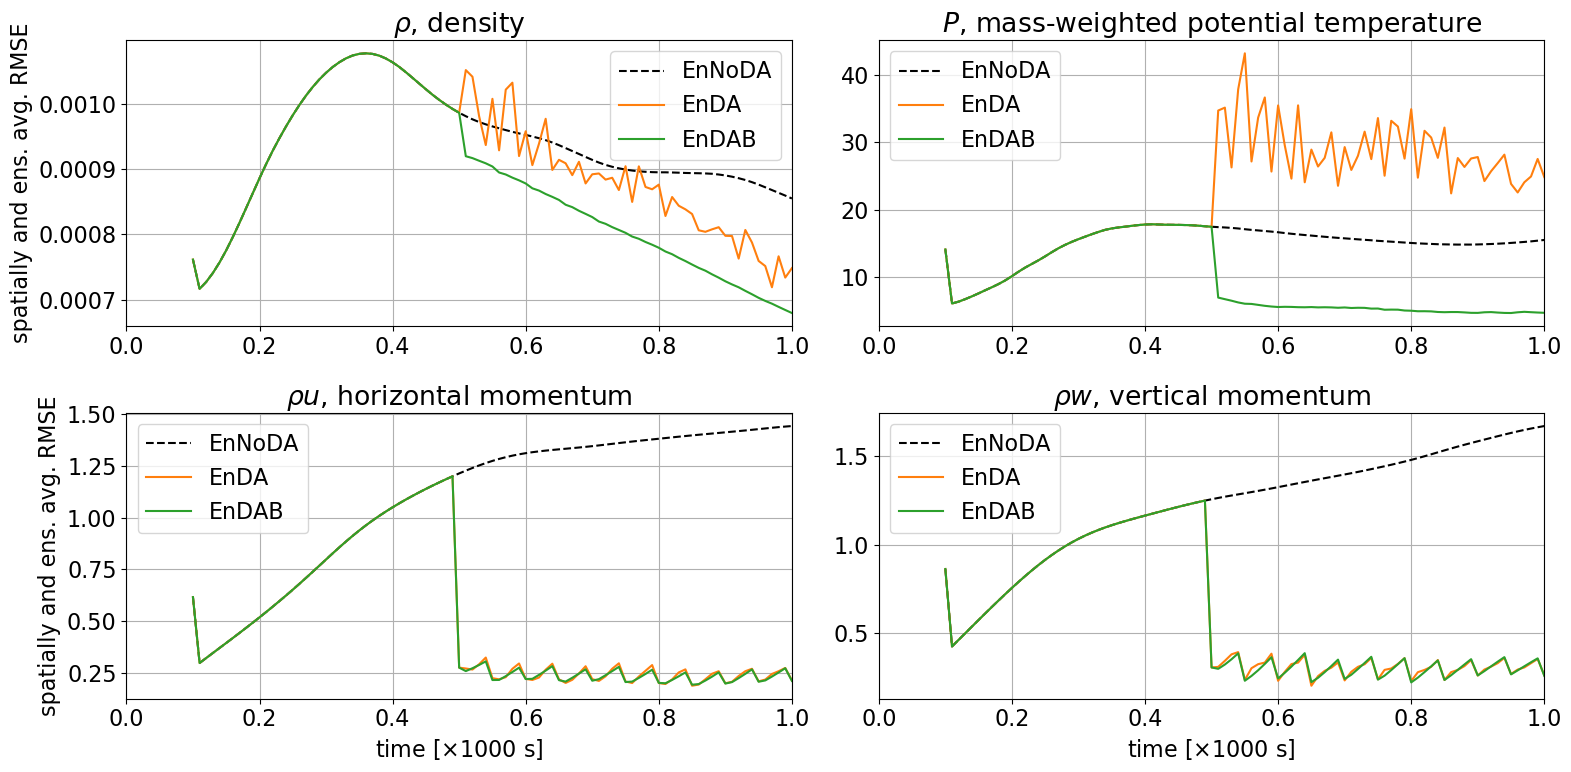

In [33]:
import matplotlib.pyplot as plt

plt.style.use('default')

fs = (16,8) # MWR and arXiv
nrows = 2
if MWR:
    pl = pt.plotter_1d(figsize=fs,fontsize=16,ncols=2,nrows=nrows)
elif arXiv:
    pl = pt.plotter_1d(figsize=fs,fontsize=16,ncols=2,nrows=nrows)

def ic_loader(tc, N, sfx, lbl):
    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    file.close()

    return ud

def unitify(arr,attribute,tc,N,sfx,lbl):
    ud = ic_loader(tc,N,sfx,lbl)
    if swe:
        if attribute == 'rho' or attribute == 'p2_nodes':
            arr *= ud.h_ref
        if attribute == 'rhou' or attribute == 'rhow':
            arr *= ud.h_ref * ud.u_ref
    else:
        if attribute == 'rho':
            arr *= ud.rho_ref
        if attribute == 'rhou' or attribute == 'rhov':
            arr *= ud.rho_ref * ud.u_ref
        if attribute == 'rhoY' or attribute == 'p2_nodes':
            arr *= ud.p_ref
            if lbl == 'euler':
                arr /= 1000.0 # units in kPa for the Euler RMSEs in rhoY and p2_nodes
        
    if attribute == 'p2_nodes':
        arr *= ud.Msq
    return arr
    

def get_ens(sfx,attribute,lbl,diff=False):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type='TIME', avg=True, diff=diff)[1:]
    if swe:
        ens = ens[:,:,0,:]
        
    ens = unitify(ens, attribute, tc, N, sfx, lbl)
        
    return ens

for i,attribute in enumerate(attributes):
    gt = 'n' if attribute == 'p2_nodes' else 'c'
    
    ens_noda = get_ens(ens_noda_suffix,attribute,lbl)
    ens_1 = get_ens(ens_1_suffix,attribute,lbl)
    ens_2 = get_ens(ens_2_suffix,attribute,lbl)

    if euler:
        ens_3 = get_ens(ens_3_suffix,attribute,lbl)
        ens_4 = get_ens(ens_4_suffix,attribute,lbl)

    truth = tc.get_ensemble(times, 1, attribute, 'truth%s_ib-0' %aux_ref, label_type='TIME',avg=True)
    if swe: truth = truth[:,:,0,:]
    truth = unitify(truth, attribute, tc, 1, 'truth%s_ib-0' %aux_ref,lbl)

    ax = pl.get_ax(i)
    avg = False

    diff_noda = tc.spatially_averaged_rmse(ens_noda,truth,avg=avg,grid_type=gt)
    diff_ens_1 = tc.spatially_averaged_rmse(ens_1,truth,avg=avg,grid_type=gt)
    diff_ens_2 = tc.spatially_averaged_rmse(ens_2,truth,avg=avg,grid_type=gt)
    if euler:
        diff_ens_3 = tc.spatially_averaged_rmse(ens_3,truth,avg=avg,grid_type=gt)
        diff_ens_4 = tc.spatially_averaged_rmse(ens_4,truth,avg=avg,grid_type=gt)
#     ax.set_ylabel('spatial and ens. averaged RMSE')
#     if swe:
#         ax.set_xlabel(r'time [$\times 100$ s]', ha='center', va='center', labelpad=5)
#     else:
#         ax.set_xlabel(r'time [$\times 100$ s]', ha='center', va='center')
    
    l1 = ax.plot(times,diff_noda, 'k--', label=ens_noda_label)
    l2 = ax.plot(times,diff_ens_1, 'C1', label=ens_1_label)
    l3 = ax.plot(times,diff_ens_2, 'C2', label=ens_2_label)
    if euler:
        l4 = ax.plot(times,diff_ens_3, 'C1--', label=ens_3_label)
        l5 = ax.plot(times,diff_ens_4, 'C2--', label=ens_4_label)

    ax.set_title("%s" %attr_labels[attribute])
    ax.set_xlim([0.0,times[-1]])
    ax.grid()
    if not euler:
        ax.legend()
    
    plt.tight_layout(rect=[-0.0, -0.0, 1.0, 1.0])
    
    if MWR:
        if attribute == 'rho':
            ax.set_ylabel("spatially and ens. avg. RMSE")
        elif attribute == 'rhou':
            ax.set_ylabel("spatially and ens. avg. RMSE")
    elif arXiv:
        if attribute == 'rho':
            ax.set_ylabel("RMSE")
        elif attribute == 'rhou':
            ax.set_ylabel("RMSE")
    if euler:
        if attribute == 'rhou':
            ax.set_xlabel(r'time [$\times 100$ s]')
        elif attribute == 'rhov':
            ax.set_xlabel(r'time [$\times 100$ s]')
    elif rb:
        if attribute == 'rhou':
            ax.set_xlabel(r'time [$\times 1000$ s]')
        elif attribute == 'rhov':
            ax.set_xlabel(r'time [$\times 1000$ s]')
    
if euler:
    pl.fig.tight_layout()
    if MWR:
        pl.fig.subplots_adjust(bottom=0.22)
    elif arXiv:
        pl.fig.subplots_adjust(bottom=0.22)
    pl.fig.legend((l1, l2, l3, l4, l5), 
                  labels=('EnNoDA', r'EnDA $\{ \rho u, \rho w \}$', r'EnDAB $\{ \rho u, \rho w \}$', 
                          r'EnDA $\{ \rho, \rho u, \rho w, P, \pi \}$', r'EnDAB $\{ \rho, \rho u, \rho w, P, \pi \}$'),
#                   ncol=5,
                  ncol=3,
                  loc='lower center',
                  bbox_to_anchor=(0.5, -0.01, 0.0, 0.0),
                  fontsize='large'
                 )
    
# plt.tight_layout()
plt.savefig('./output/%sRmse.pdf' %(lbl), bbox_inches="tight")
plt.show()

## Plot the ensemble members

16
0 -161.66587597608023 47.99026539044703
1 -196.84638011665166 50.674580670495395
2 -110.9654052125548 40.42125824542315
3 -106.30148510649083 45.07508738342635
4 -197.3652521192994 149.0382879178047
5 -262.55256334113176 322.02330612173324
6 -152.1690816162891 120.97663385250695
7 -160.85042702296676 109.42412082195361
8 -108.4729669525386 47.809259611713316
9 -109.06565045490217 58.087262167441644
10 -119.97644524528407 41.893504646483905
11 -110.0391008844158 45.279674240898295
12 -183.58757801903036 142.7631393967472
13 -194.31351521040483 335.5217783983903
14 -89.60377569023555 117.9135928336917
15 -95.59749528624636 110.51970135871717


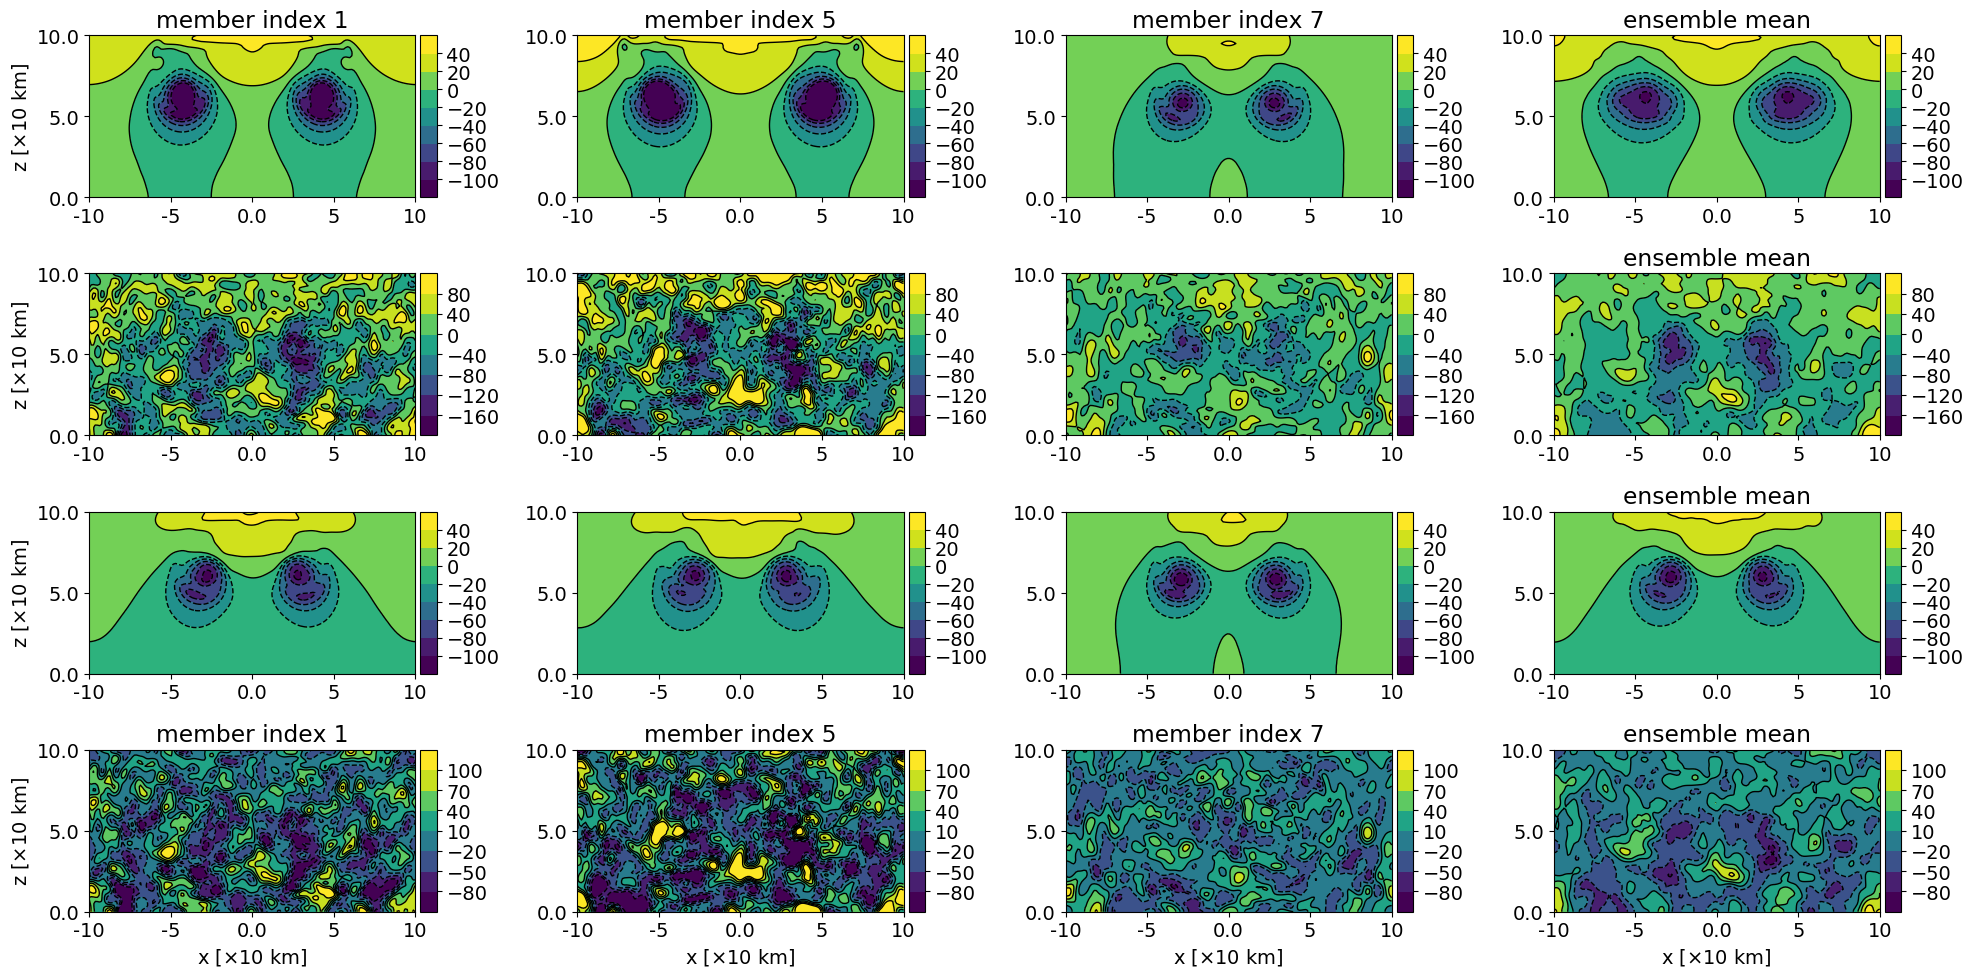

In [34]:
# plot pressure / water depth perturbation
attributes = ['p2_nodes']
# attributes = ['rho']

# plot the very last output
ens_time = [times[-1]] 
tag = tags[9]

class oo(object): pass
ens0_oo = oo()
ens1_oo = oo()
ens_ref_oo = oo()

if euler:
    ens_1_suffix = ens_3_suffix
    ens_2_suffix = ens_4_suffix

if len(attributes) > 1:
    # for plotting of derived quantities, e.g. u,v,w, and Theta.
    for attribute in attributes:
        ens0 = tc.get_ensemble(times, N, attribute, ens_1_suffix, tag=tag, inner=True)[-1]
        ens1 = tc.get_ensemble(times, N, attribute, ens_2_suffix, tag=tag, inner=True)[-1]
        ens_ref = tc.get_ensemble(times, N, attribute, ens_noda_suffix, tag=tag, inner=True)[-1]
        setattr(ens0_oo,attribute,ens0)
        setattr(ens1_oo,attribute,ens1)
        setattr(ens_ref_oo,attribute,ens_ref)

    ens0 = getattr(ens0_oo,attributes[1]) / getattr(ens0_oo,attributes[0])
    ens1 = getattr(ens1_oo,attributes[1]) / getattr(ens1_oo,attributes[0])
    ens_ref = getattr(ens_ref_oo,attributes[1]) / getattr(ens_ref_oo,attributes[0])
else:
    ens0 = tc.get_ensemble(times, N, attributes[0], ens_1_suffix, tag=tag, inner=True)[-1]
    ens1 = tc.get_ensemble(times, N, attributes[0], ens_2_suffix, tag=tag, inner=True)[-1]
    ens_ref = tc.get_ensemble(times, N, attributes[0], ens_noda_suffix, tag=tag, inner=True)[-1]
    
    ens0_rhoY = tc.get_ensemble(times, N, 'rhoY', ens_1_suffix, tag=tag, inner=True)[-1]
    ens1_rhoY = tc.get_ensemble(times, N, 'rhoY', ens_2_suffix, tag=tag, inner=True)[-1]
    ens_ref_rhoY = tc.get_ensemble(times, N, 'rhoY', ens_noda_suffix, tag=tag, inner=True)[-1]
    
def p_converter(ens,rhoY,ud):
    dp2n = np.array([ (mem - mem.mean()) * ud.Msq for mem in ens ])
    kernel = np.ones((2,2))
    dp2c = np.array([signal.fftconvolve(mem, kernel, mode='valid') / kernel.sum() for mem in dp2n])

    P0 = (rhoY**(ud.gamm-1.0) - dp2c)**(1.0/(ud.gamm-1.0))
    p = rhoY**(ud.gamm) - P0**(ud.gamm)
    p *= ud.p_ref
    return p


def ic_loader(tc, sfx, lbl):
    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    file.close()
    
#     if lbl == 'swe':
#         p_ref = ud.h_ref * ud.Msq
#     elif lbl == 'euler':
#         p_ref = ud.p_ref * ud.Msq
#     elif lbl =='rb':
#         p_ref = ud.p_ref * ud.Msq

#     return p_ref
    return ud

ud = ic_loader(tc,ens_1_suffix,lbl)

ens_ref = p_converter(ens_ref, ens_ref_rhoY, ud)
ens0 = p_converter(ens0, ens0_rhoY, ud)
ens1 = p_converter(ens1, ens1_rhoY, ud)

enses = [ens_ref, ens0, ens1]
sfxes = [ens_noda_suffix, ens_1_suffix, ens_2_suffix]

if swe:
    mean0 = np.mean(ens0,axis=0)[:,0,:] 
    mean1 = np.mean(ens1,axis=0)[:,0,:]
    mean_ref = np.mean(ens_ref,axis=0)[:,0,:]
else:
    mean0 = np.mean(ens0,axis=0)
    mean1 = np.mean(ens1,axis=0)
    mean_ref = np.mean(ens_ref,axis=0)

diff = False
if diff == True:
    mean0 -= mean_ref
    mean1 -= mean_ref

if MWR:
    mean0 = [mean0.T,'ensemble mean']
    mean1 = [mean1.T,'ensemble mean']
    mean_ref = [mean_ref.T,'ensemble mean']
elif arXiv:
    mean0 = [mean0.T,'']
    mean1 = [mean1.T,'']
    mean_ref = [mean_ref.T,'ensemble mean']
means = [mean_ref, mean0, mean1]

arr_lst = []
lvls = []
ens_store, ens_diff = [], []
for bb,ens in enumerate(enses):
    sfx = sfxes[bb]
    fs = (14,8)
        
    ens_arr = []
    for n,arr in enumerate(ens):
        arr_ref = ens_ref[n]
        if swe:
            arr_ref = arr_ref[:,0,:].T
            arr = arr[:,0,:].T
        else:
            arr_ref = arr_ref.T
            arr = arr.T

        if diff == True:
            arr -= arr_ref
            
        if rb:
            if bb == 1:
                ens_store.append(arr)
            if bb == 2:
                if MWR:
                    ens_diff.append([ens_store[n] - (arr), 'member index %i' %n])
                elif arXiv:
                    ens_diff.append([ens_store[n] - (arr), ''])
        
        if bb == 0:
            if MWR:
                ens_arr.append([arr, 'member index %i' %n])
            elif arXiv:
                ens_arr.append([arr, 'member index %i' %n])
        else:
            ens_arr.append([arr, ''])
            

    # which members to plot?
    arr_lst += [ens_arr[1],ens_arr[5],ens_arr[7]]
    # append mean to plot
    arr_lst.append(means[bb])

    if rb:
        # exner levels
#         if bb == 0:
#             lvls += [np.arange(-50,40,10)]*4
#         elif bb == 1:
#             lvls += [np.arange(-70,60,20)]*4
#         elif bb == 2:
#             lvls += [np.arange(-50,40,10)]*4
        # pressure levels
        if bb == 0:
            lvls += [np.arange(-100,60,20)]*4
        elif bb == 1:
#             lvls += [np.arange(-70,60,20)]*4
            lvls += [np.arange(-160,120,40)]*4
        elif bb == 2:
#             lvls += [np.arange(-50,40,10)]*4
            lvls += [np.arange(-100,60,20)]*4
            
        
    if euler:
#         # exner levels
#         if bb == 0:
#             lvls += [np.arange(-55,15,10)]*4
#         elif bb == 1:
#             lvls += [np.arange(-550.0,650.0,150.0)]*4
#         elif bb == 2:
#             lvls += [np.arange(-70,10,10)]*4
        # pressure levels
        if bb == 0:
            lvls += [np.arange(-200,40,40)]*4
        elif bb == 1:
#             lvls += [np.arange(-550.0,650.0,150.0)]*4
            lvls += [np.arange(-1900,1300+640,640)]*4
        elif bb == 2:
            lvls += [np.arange(-200,40,40)]*4
    
if rb:
    # which member-diffs to plot?
    arr_lst += [ens_diff[1],ens_diff[5],ens_diff[7]]
    # append mean to plot
    if MWR:
        mean_diff = [means[1][0] - means[2][0], 'ensemble mean']
    elif arXiv:
        mean_diff = [means[1][0] - means[2][0], '']
    arr_lst.append(mean_diff)
#     lvls += [np.arange(-30,50,10)]*4 # exner levels
    lvls += [np.arange(-80,130,30)]*4 # pressure levels
print(len(lvls))

for idx, arr in enumerate(arr_lst):
    if idx % 4 == 0:
        print("===========")
    print(idx, arr[0].min(),arr[0].max())

# if attributes[0] == 'p2_nodes':
#     nnx, nnz = axs0, axs1
#     axh, axv = 32, 32
# else:
nnx, nnz = axs0-1,axs1-1
    
narr_lst = np.array(arr_lst)
ncolslen = 4
if MWR:
    fs = (20,10) if rb else (16,10)
elif arXiv:
    fs = (16,9) if rb else (13,7)
pl = pt.plotter(arr_lst,ncols=ncolslen,figsize=fs,sharexlabel=True,shareylabel=True)

x_label = r'x [$\times 10$ km]'
y_label = r'z [$\times 10$ km]'

if rb:
    x_loc = np.linspace(0,nnx,5)
    y_loc = np.linspace(0,nnz,3)
    axh, axv = 39.5, 79.5
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
#     pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, axhline = axh, axvline = axv, x_label=x_label, y_label=y_label)
else:
    x_loc = np.linspace(0,nnx,3)
    y_loc = np.linspace(0,nnz,3)
    axh, axv = 31.5, 31.5
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, axhline = axh, axvline = axv, x_label=x_label, y_label=y_label)

# mthd = 'imshow' if rb else 'contour'
mthd = 'contour'
_ = pl.plot(aspect='equal',method=mthd, lvls=lvls)

pl.save_fig('./output/%s_enses' %lbl)